In [1]:
%matplotlib agg
import itertools
from collections import OrderedDict

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.spatial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tqdm
import torch
import tables
import torchgraphs as tg

from IPython.display import display, Markdown

aminoacids = list('ACDEFGHIKLMNOPQRSTUVWY') + ['None']

In [2]:
h5_file = tables.open_file('../data/training_casp9_10.v4.h5')

## All proteins

In [4]:
from proteins.utils import RunningStats

#all_distances = RunningStats()
all_neighbor_distances = RunningStats()
for protein in h5_file.list_nodes('/'):
    for model_idx in range(len(protein.names)):
        residue_mask = protein.valid_dssp[model_idx]                   # which residues are actually present in this model
        coordinates = protein.cb_coordinates[model_idx][residue_mask]  # coordinates of the β carbon (or α if β is not present)
        #distances = scipy.spatial.distance.pdist(coordinates)          # flattened pairwise distances between residues
        #all_distances.add_from(distances)
        neighbor_distances = np.sqrt(np.square(coordinates[:-1] - coordinates[1:]).sum(axis=1))
        all_neighbor_distances.add_from(neighbor_distances)
#print(all_distances)
print(all_neighbor_distances)

5.350942490574513 ± 0.9335879838891673 (min: 0.009695247747004032, max: 375.2893371582031, count: 13150162)


## Protein T0538
Here we have the target T0538 of length 54 and with 280 models (the native structure plus 279 models). 
- dssp contains the structural inputs (secondary structure and torsion angles)
- lddt is the local quality scores
- seq, part_entr and self_info are the sequence information (common to all of them).
- valid_dssp is a boolean vector that indicates if the residue is present in the model (some models have missing residues)
- valid indicates if the residue is present in the experimental structure, hence we can know its actual quality. Some residues are missing, so we just ignore those.

In [3]:
protein = h5_file.get_node('/T0538')

What is this sequence? Is the sequence of the "native" model?

In [5]:
protein.valid.shape

(280, 54)

In [6]:
sequence_len = protein.seq.shape[1]
num_models = len(protein.names)
print(' '.join(aminoacids[i] for i in np.argmax(protein.seq[0], axis=1)))
print(' '.join('^' if v else ' ' for v in protein.valid[0]))
print('Number of models:', num_models)

M O N S U T R E A L T L N L O I Q H H A S R P A L A S I E P N A S P A E P F I V T Q E N V E P A S N E H G P
  ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^
Number of models: 280


### Overview

#### Self information

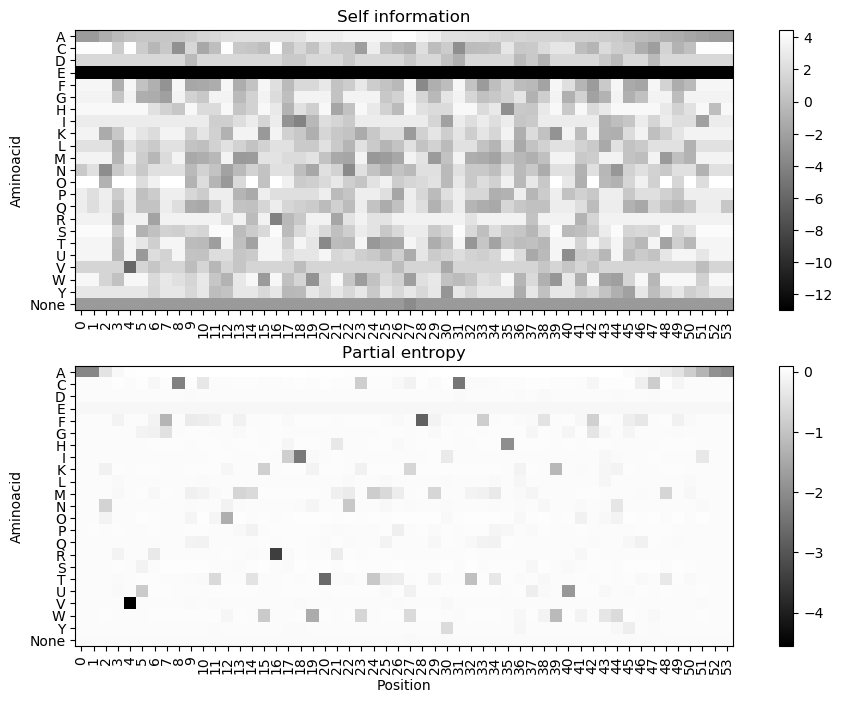

In [7]:
fig = plt.figure(figsize=(12, 8))
gs = plt.GridSpec(2, 1)

ax = fig.add_subplot(gs[0, 0])
img = ax.imshow(protein.self_info[0].T, cmap='gray')
ax.set_yticks(np.arange(23))
ax.set_yticklabels(aminoacids)
ax.set_ylabel('Aminoacid')
ax.set_xticks(np.arange(len(protein.seq[0])))
ax.set_xticklabels(np.arange(len(protein.seq[0])), rotation=90)
ax.set_title('Self information')

fig.colorbar(img, ax=ax)

ax = fig.add_subplot(gs[1, 0])
img = ax.imshow(protein.part_entr[0].T, cmap='gray')
ax.set_yticks(np.arange(23))
ax.set_yticklabels(aminoacids)
ax.set_ylabel('Aminoacid')
ax.set_xticks(np.arange(len(protein.seq[0])))
ax.set_xticklabels(np.arange(len(protein.seq[0])), rotation=90)
ax.set_xlabel('Position')
ax.set_title('Partial entropy')

fig.colorbar(img, ax=ax)

display(fig)

#### Models scores

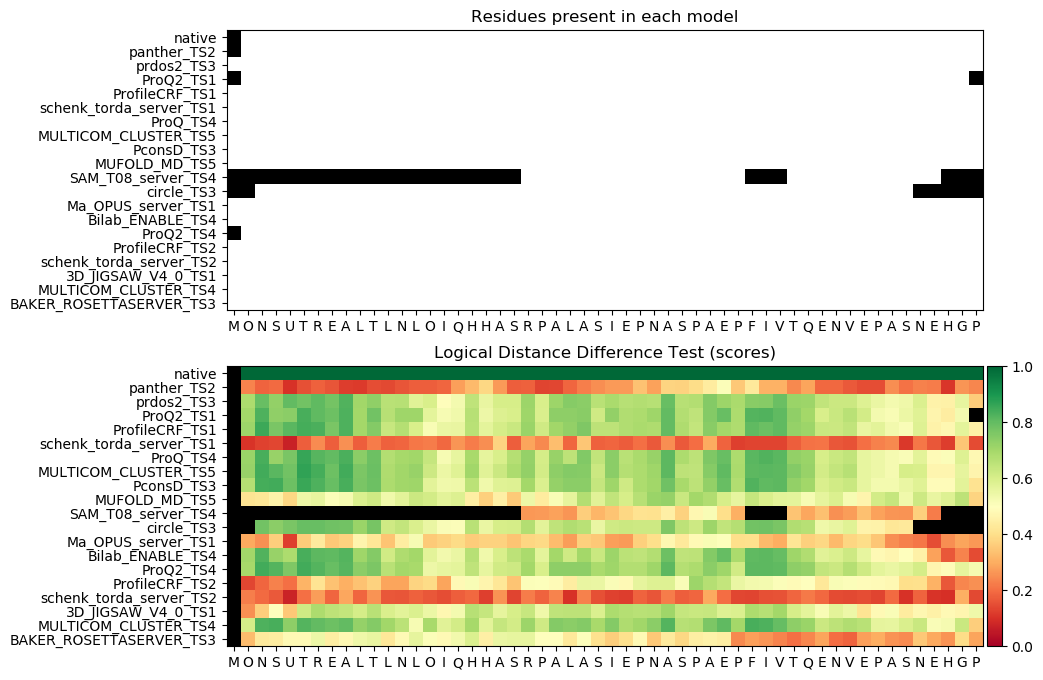

In [8]:
fig = plt.figure(figsize=(10, 8))
gs = plt.GridSpec(2, 2, width_ratios=[50, 1], wspace=0.01)

ax = fig.add_subplot(gs[0, :-1])
ax.imshow(protein.valid_dssp[:20], cmap='gray')
ax.set_yticks(np.arange(20))
ax.set_yticklabels([n.decode('utf-8') for n in protein.names[:20]])
ax.set_xticks(np.arange(len(protein.seq[0])))
ax.set_xticklabels([aminoacids[i] for i in np.argmax(protein.seq[0], axis=1)])
ax.set_title('Residues present in each model')

ax = fig.add_subplot(gs[1, :-1], sharex=ax)
img = ax.imshow(np.ma.masked_where(np.logical_not(protein.valid[:20]), protein.lddt[:20]), cmap='RdYlGn', vmin=0, vmax=1)
ax.imshow(np.ma.masked_where(protein.valid[:20], np.zeros_like(protein.lddt[:20])), cmap='gray')
ax.set_yticks(np.arange(20))
ax.set_yticklabels([n.decode('utf-8') for n in protein.names[:20]])
ax.set_xticks(np.arange(len(protein.seq[0])))
ax.set_xticklabels([aminoacids[i] for i in np.argmax(protein.seq[0], axis=1)])
ax.set_title('Logical Distance Difference Test (scores)')

ax = fig.add_subplot(gs[1, -1])
fig.colorbar(img, cax=ax)

display(fig)

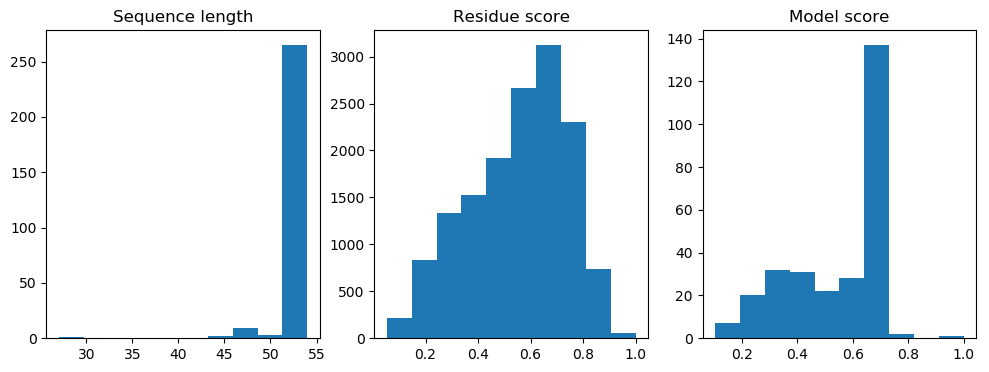

In [9]:
fig = plt.figure(figsize=(12, 4))
gs = plt.GridSpec(1, 3)

ax = fig.add_subplot(gs[0])
ax.hist(np.array(protein.valid_dssp).sum(axis=1))
ax.set_title('Sequence length')

ax = fig.add_subplot(gs[1])
ax.hist(np.array(protein.lddt)[np.array(protein.valid)])
ax.set_title('Residue score')

ax = fig.add_subplot(gs[2])
ax.hist(np.array(protein.lddt_global))
ax.set_title('Model score')

display(fig)

### Models

#### Model 0: native
native

,residue,3-state,6-state,surface acc,φ,ψ,score
0,O,C,C,87.69%,-0.0,160.4,1
1,N,C,C,13.93%,-101.2,178.4,1
2,S,E,H,63.87%,-83.9,112.3,1
3,U,E,H,16.14%,-92.1,124.2,1
4,T,C,C,18.60%,-70.9,157.4,1
5,R,H,GI,53.55%,-57.1,-39.1,1
6,E,H,GI,48.43%,-67.2,-40.7,1
7,A,H,GI,0.00%,-63.6,-43.0,1
8,L,H,GI,45.76%,-54.5,-46.5,1
9,T,H,GI,45.35%,-64.2,-41.5,1


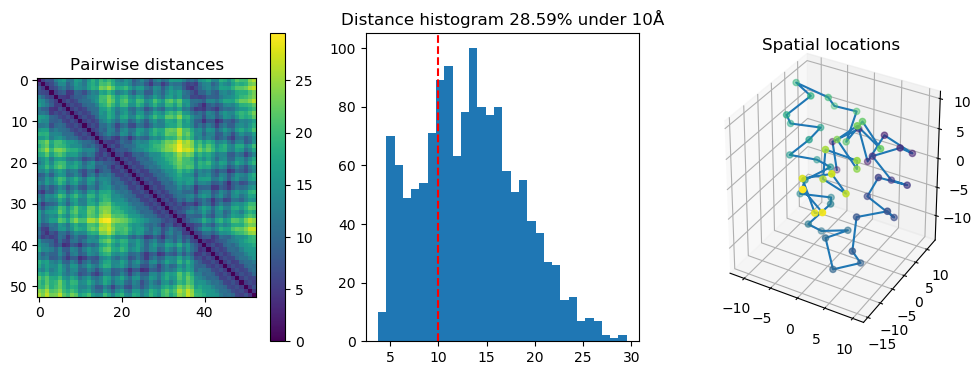

#### Model 2: prdos2_TS3
one residue more than the native model

,residue,3-state,6-state,surface acc,φ,ψ,score
0,M,C,C,99.55%,-0.0,-129.6,nan
1,O,C,C,51.79%,-71.7,165.7,0.684
2,N,C,C,7.46%,-74.8,164.4,0.7947
3,S,E,H,57.30%,-91.1,129.1,0.7296
4,U,E,H,14.04%,-106.9,140.3,0.8029
5,T,C,C,20.35%,-94.6,159.8,0.7796
6,R,H,GI,60.65%,-65.7,-29.0,0.8067
7,E,H,GI,52.47%,-64.7,-44.2,0.7772
8,A,H,GI,0.00%,-67.3,-42.1,0.8271
9,L,H,GI,22.46%,-64.1,-35.9,0.705


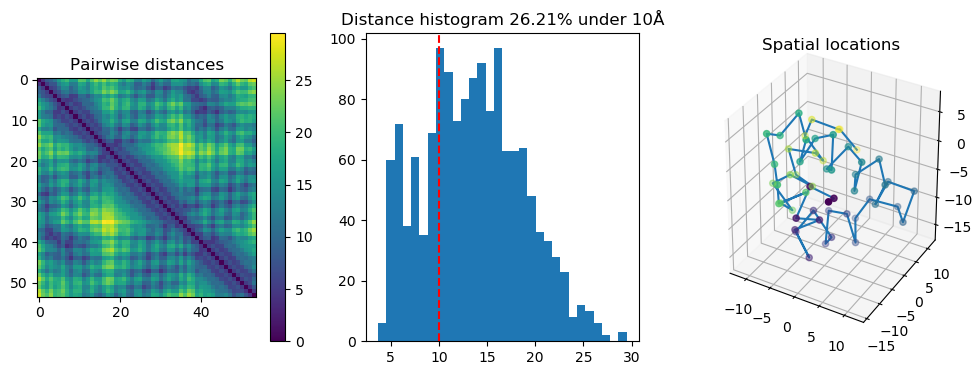

#### Model 10: SAM_T08_server_TS4
one residue less than the native model

,residue,3-state,6-state,surface acc,φ,ψ,score
0,R,C,C,87.10%,-0.0,-38.9,0.2694
1,P,H,GI,65.78%,-64.1,-45.0,0.2733
2,A,H,GI,37.98%,-64.8,-39.5,0.284
3,L,H,GI,63.14%,-64.0,-38.2,0.2646
4,A,H,GI,41.86%,-66.1,-39.4,0.3654
5,S,H,GI,47.81%,-64.6,-40.0,0.3182
6,I,H,GI,23.86%,-58.1,-50.4,0.3442
7,E,H,GI,57.85%,-61.8,-41.9,0.386
8,P,H,GI,36.44%,-58.5,-47.3,0.4131
9,N,H,GI,45.27%,-63.5,-43.6,0.4094


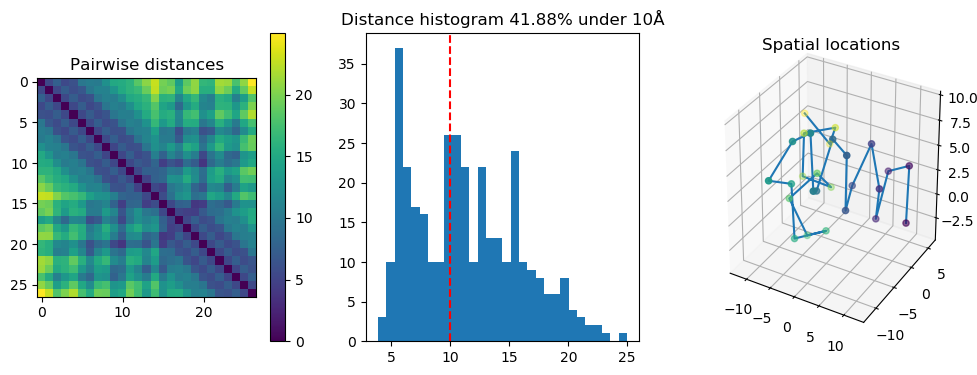

In [10]:
for model_idx, comment in {
    0: 'native',
    2: 'one residue more than the native model',
    10: 'one residue less than the native model',
}.items():
    provider = protein.names[model_idx].decode('utf-8')            # who built this model of the protein

    residue_mask = protein.valid_dssp[model_idx]                   # which residues are actually present in this model
    residues = protein.seq[0][residue_mask]                        # one-hot encoding of the residues present in this model
    partial_entropy = protein.part_entr[0][residue_mask]           # partial entropy of the residues
    self_information = protein.self_info[0][residue_mask]          # self information of the residues
    secondary_structure = protein.dssp[model_idx][residue_mask]    # secondary structure features

    coordinates = protein.cb_coordinates[model_idx][residue_mask]  # coordinates of the β carbon (or α if β is not present)
    distances = scipy.spatial.distance.pdist(coordinates)          # pairwise distances between residues

    valid_scores = protein.valid[model_idx][residue_mask]          # of the residues present in this model, only those that are also present in the exprimental model have a score
    scores = protein.lddt[model_idx][residue_mask]                 # quality scores of the residues
    global_score = protein.lddt_global[model_idx]                  # quality score of the whole model
    
    display(Markdown(f'#### Model {model_idx}: {provider}\n{comment}'))
    
    df = pd.DataFrame({
        'residue': [aminoacids[i] for i in np.argmax(residues, axis=1)],
        '3-state': ['HEC'[s] for s in np.argmax(secondary_structure[:, :3], axis=1)],
        '6-state': ['GI,H,E,B,TS,C'.split(',')[s] for s in np.argmax(secondary_structure[:, 3:3+6], axis=1)],
        'surface acc': secondary_structure[:, 9],
        'φ': np.degrees(np.arctan2(secondary_structure[:, 10], secondary_structure[:, 11])),
        'ψ': np.degrees(np.arctan2(secondary_structure[:, 12], secondary_structure[:, 13])), 
        'score': scores
    })

    display(
        df
        .style
        .format({'surface acc': '{:.2%}', 'φ': '{:.1f}', 'ψ': '{:.1f}'})
        .apply(lambda _: np.where(valid_scores, '', 'color: red'), subset=pd.IndexSlice[:, ['score']], axis='index')
        .bar(subset=['score'], color='green', vmin=0, vmax=1)
        .bar(subset=['surface acc'], color='pink', vmin=0, vmax=1)
        .bar(subset=['φ', 'ψ'], color=['turquoise', 'orange'], align='zero', vmin=-180, vmax=180)
    )

    fig = plt.figure(figsize=(12, 4))
    gs = plt.GridSpec(1, 3)

    ax = fig.add_subplot(gs[0])
    img = ax.imshow(scipy.spatial.distance.squareform(distances))
    ax.set_title('Pairwise distances')
    plt.colorbar(img, ax=ax)

    ax = fig.add_subplot(gs[1])
    ax.hist(distances, bins=30);
    ax.axvline(10, color='red', linestyle='--')
    ax.set_title(f'Distance histogram {(distances < 10).sum() / len(distances):.2%} under 10Å')
    
    ax = fig.add_subplot(gs[2], projection='3d')
    ax.plot(*coordinates.T);
    ax.scatter(*coordinates.T, c=np.linspace(0,1,len(coordinates)));
    ax.set_title('Spatial locations')

    display(fig)

### Build graph

Normalization for distances:
- neighboring residues are at around 5Å
- after 10Å the influence is negligible

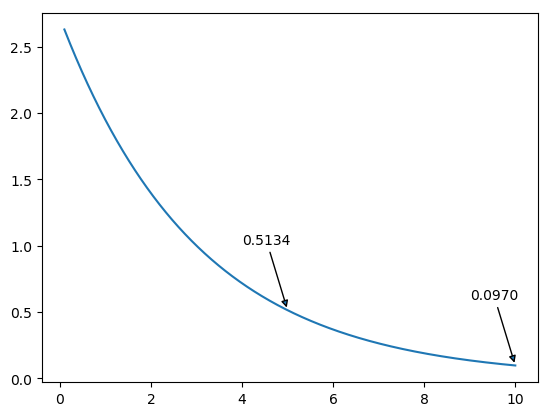

In [11]:
x = np.linspace(0.1,10, 10000)
f = lambda x: np.exp(- (x - 3)  / 3)
y = f(x)
fig, ax = plt.subplots(1,1)
ax.plot(x, y)
ax.annotate(f'{f(10):.4f}', (10, f(10)), xytext=(10 - 1, f(10) + .5), arrowprops={'arrowstyle': '-|>'})
ax.annotate(f'{f(5):.4f}', (5, f(5)), xytext=(5 - 1, f(5) + .5), arrowprops={'arrowstyle': '-|>'})
display(fig)

In [20]:
model_idx = 2

provider = protein.names[model_idx].decode('utf-8')            # who built this model of the protein

residue_mask = protein.valid_dssp[model_idx]                   # which residues are actually present in this model
residues = protein.seq[0][residue_mask]                        # one-hot encoding of the residues present in this model
partial_entropy = protein.part_entr[0][residue_mask]           # partial entropy of the residues
self_information = protein.self_info[0][residue_mask]          # self information of the residues
secondary_structure = protein.dssp[model_idx][residue_mask]    # secondary structure features

coordinates = protein.cb_coordinates[model_idx][residue_mask]  # coordinates of the β carbon (or α if β is not present)
distances = scipy.spatial.distance.pdist(coordinates)          # pairwise distances between residues

valid_scores = protein.valid[model_idx][residue_mask]          # of the residues present in this model, only those that are also present in the exprimental model have a score
scores = protein.lddt[model_idx][residue_mask]                 # quality scores of the residues
global_score = protein.lddt_global[model_idx]                  # quality score of the whole model

N = len(residues)

distances_idx = distances < 10
senders, receivers = np.triu_indices(N, k=1)
senders = senders[distances_idx]
receivers = receivers[distances_idx]

graph_in = tg.Graph(
    num_nodes=N,
    node_features=torch.from_numpy(np.concatenate([
        #residues,
        partial_entropy,
        self_information,
        secondary_structure
    ], axis=1)).float(),
    num_edges=2 * np.count_nonzero(distances_idx),
    senders=torch.from_numpy(np.concatenate((senders, receivers))),
    receivers=torch.from_numpy(np.concatenate((receivers, senders))),
    edge_features=torch.from_numpy(- (distances[distances_idx] - 3) / 3).exp_().repeat(2).view(-1, 1).float()
)
graph_target = tg.Graph(
    num_nodes=N,
    node_features=torch.from_numpy(scores).view(-1, 1).float(),
    global_features=torch.tensor([global_score]).float()
)
graph_in, graph_target

(Graph(n=54, e=750, n_shape=torch.Size([60]), e_shape=torch.Size([1]), g_shape=None),
 Graph(n=54, e=0, n_shape=torch.Size([1]), e_shape=None, g_shape=torch.Size([1])))